In [1]:
# сегментацю делать светлых областей (а не маски)
# написать функцию которая проверяет что полученный квадрат входит в область
# написать функцию которая высчитывает метрики похожести
# адаптивный трешолд для поиска светлых объектов

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from skimage.io import imread, imshow, imsave
from skimage.measure import label, regionprops

from skimage.segmentation import felzenszwalb

import os

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
import cv2
import random
from tqdm import tqdm

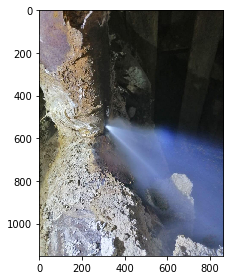

In [3]:
#path = 'photo_2020-03-03_18-30-03.jpg'
path = 'photo_2020-03-08_13-32-20.jpg' 


image = imread(os.path.join(path))
image_grey = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

imshow(image)
plt.show()

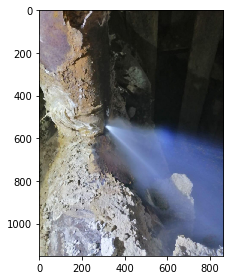

In [4]:
image_blured = cv2.medianBlur(image,5)
imshow(image_blured)
plt.show()

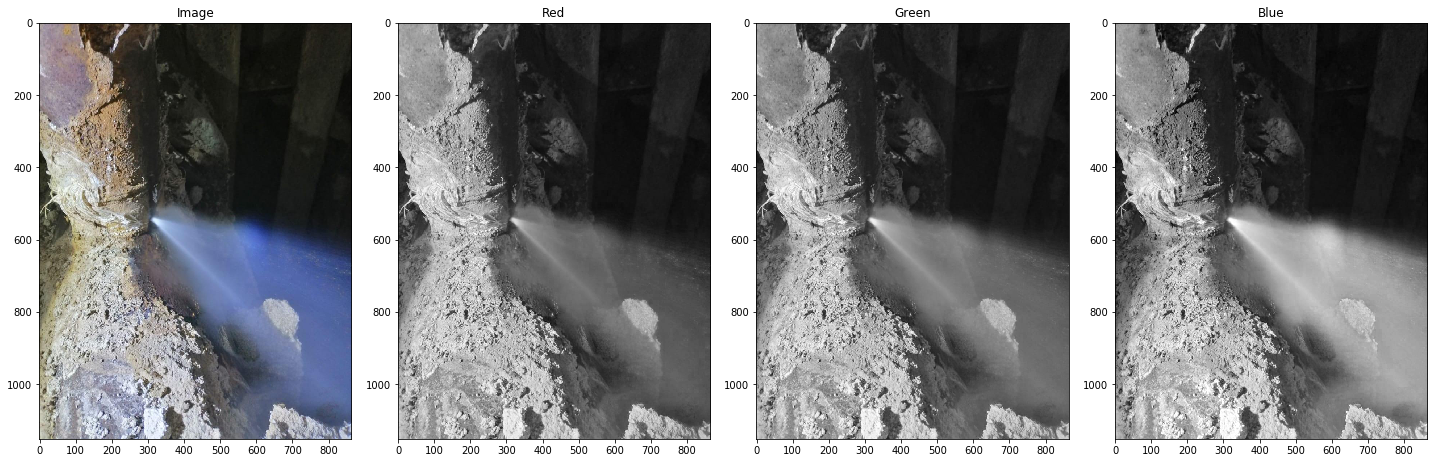

In [5]:
plt.figure(figsize=[25,25])
plt.subplot(151)
plt.title('Image')
imshow(image)

plt.subplot(152)
plt.title('Red')
imshow(image[:,:, 0])

plt.subplot(153)
plt.title('Green')
imshow(image[:,:, 1])

plt.subplot(154)
plt.title('Blue')
imshow(image[:,:, 2])

plt.show()

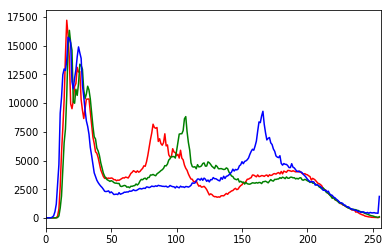

In [6]:
color = ('r','g','b')

for i,col in enumerate(color):
    histr = cv2.calcHist([image],[i],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])

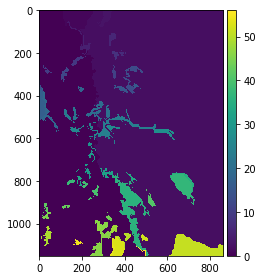

In [7]:
segments = felzenszwalb(image, scale=400, sigma=3, min_size=400)
imshow(segments)

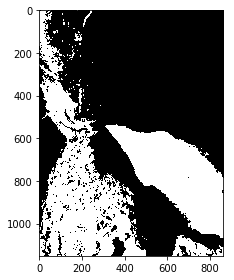

In [8]:
thresh = cv2.threshold(image_blured[:,:, 2], 150, 255, cv2.THRESH_BINARY)[1]
imshow(thresh)

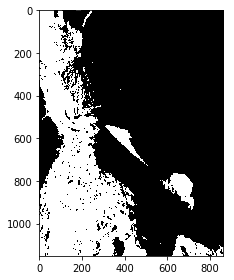

In [9]:
edge = 120
red = np.where(image_blured[:,:, 0] > edge, 1, 0)
green = np.where(image_blured[:,:, 1] > edge, 1, 0)
blue = np.where(image_blured[:,:, 2] > edge, 1, 0)
thresh = red * green * blue * 255
thresh = thresh.astype('uint8')

imshow(thresh)

In [10]:
img_treshed = image.copy()

for i in range(3):
    img_treshed[:,:,i] = image[:,:,i] * thresh

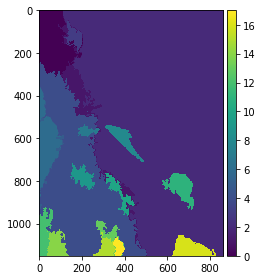

In [11]:
segments = felzenszwalb(img_treshed, scale=500, sigma=1, min_size=2000)
imshow(segments)

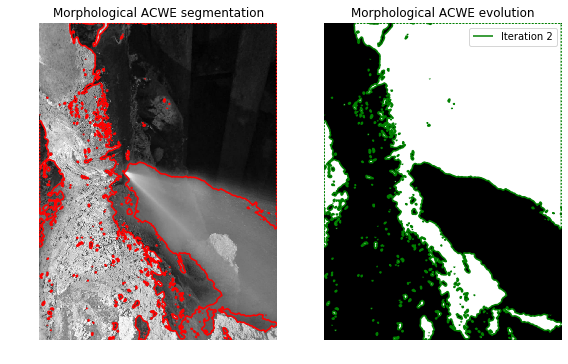

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, img_as_float
from skimage.segmentation import (morphological_chan_vese,
                                  morphological_geodesic_active_contour,
                                  inverse_gaussian_gradient,
                                  checkerboard_level_set)


def store_evolution_in(lst):
    """Returns a callback function to store the evolution of the level sets in
    the given list.
    """

    def _store(x):
        lst.append(np.copy(x))

    return _store


# Morphological ACWE
image = image_grey

# Initial level set
init_ls = checkerboard_level_set(image.shape, 6)
# List with intermediate results for plotting the evolution
evolution = []
callback = store_evolution_in(evolution)
ls = morphological_chan_vese(image, 2, init_level_set=init_ls, smoothing=3,
                             iter_callback=callback)

fig, axes = plt.subplots(1, 2, figsize=(8, 8))
ax = axes.flatten()

ax[0].imshow(image, cmap="gray")
ax[0].set_axis_off()
ax[0].contour(ls, [0.5], colors='r')
ax[0].set_title("Morphological ACWE segmentation", fontsize=12)

ax[1].imshow(ls, cmap="gray")
ax[1].set_axis_off()
contour = ax[1].contour(evolution[2], [0.5], colors='g')
contour.collections[0].set_label("Iteration 2")
# contour = ax[1].contour(evolution[7], [0.5], colors='y')
# contour.collections[0].set_label("Iteration 7")
# contour = ax[1].contour(evolution[-1], [0.5], colors='r')
# contour.collections[0].set_label("Iteration 35")
ax[1].legend(loc="upper right")
title = "Morphological ACWE evolution"
ax[1].set_title(title, fontsize=12)



fig.tight_layout()
plt.show()

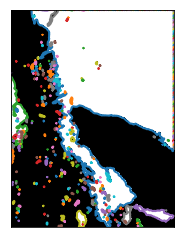

In [13]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import measure

contours = measure.find_contours(ls, 0.8)

fig, ax = plt.subplots()
ax.imshow(ls, cmap=plt.cm.gray)

for n, contour in enumerate(contours):
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

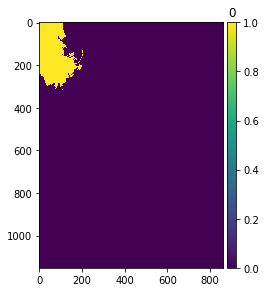

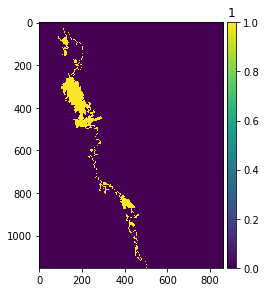

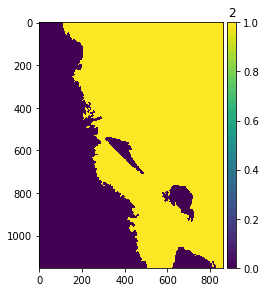

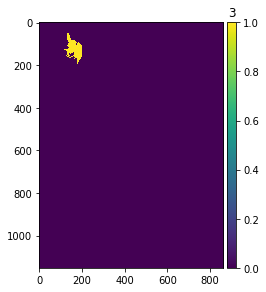

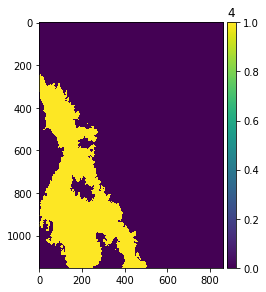

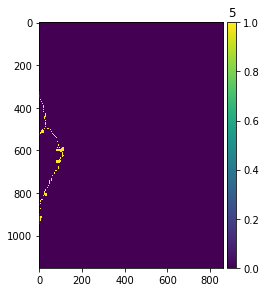

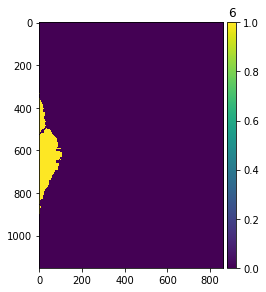

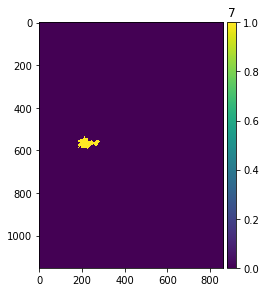

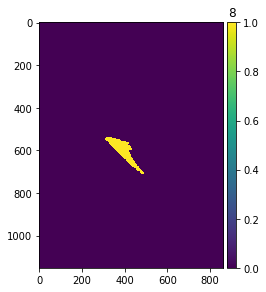

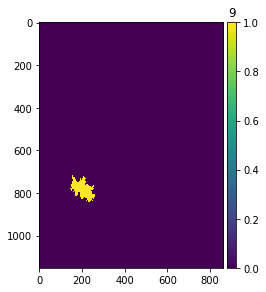

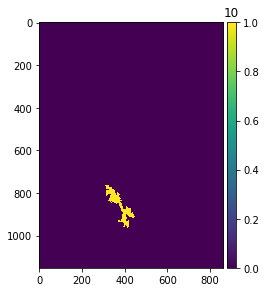

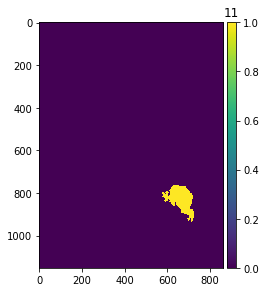

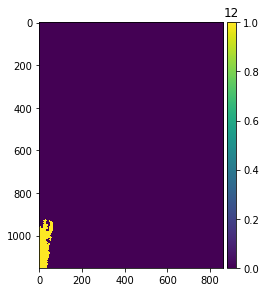

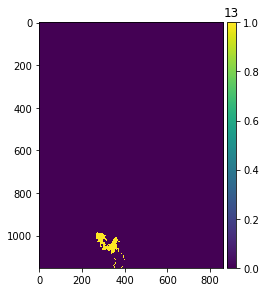

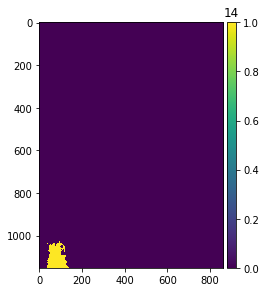

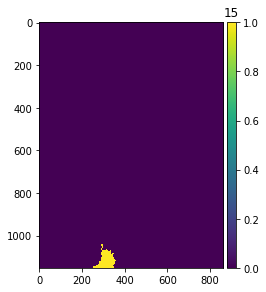

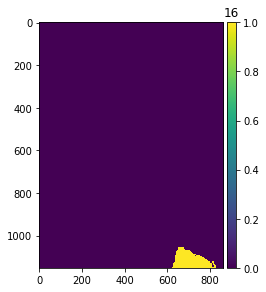

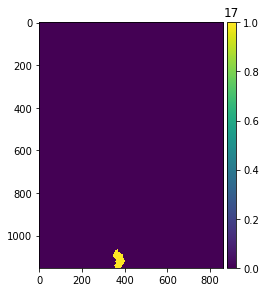

In [14]:
label_image = label(segments)
objects = np.unique(label_image)

for i in objects:
    obj = np.where(label_image == i, 1, 0)
    imshow(obj)
    plt.title(str(i))
    plt.show()

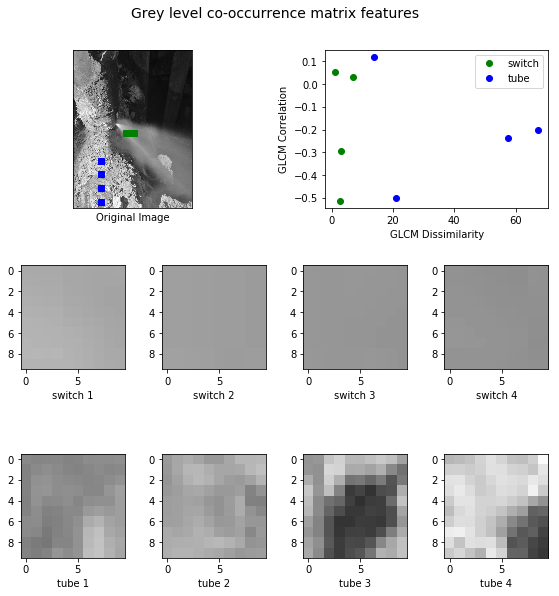

In [15]:
import matplotlib.pyplot as plt

from skimage.feature import greycomatrix, greycoprops
from skimage import data


PATCH_SIZE = 10

# open the camera image
image = image_grey

# select some patches from switchy areas of the image
switch_locations = [(600, 380), (600, 400), (600, 420), (600, 440)] #  [(480, 320), (460, 340), (440, 360), (420, 380)] 
switch_patches = []
for loc in switch_locations:
    switch_patches.append(image[loc[0]:loc[0] + PATCH_SIZE,
                               loc[1]:loc[1] + PATCH_SIZE])

# select some patches from tube areas of the image
tube_locations =  [(1100, 200), (1000, 200), (900, 200), (800, 200)]  # 
# black area
# [(200, 400), (200, 500), (200, 600), (200, 700)]

tube_patches = []
for loc in tube_locations:
    tube_patches.append(image[loc[0]:loc[0] + PATCH_SIZE,
                             loc[1]:loc[1] + PATCH_SIZE])

# compute some GLCM properties each patch
xs = []
ys = []
for patch in (switch_patches + tube_patches):
    glcm = greycomatrix(patch, distances=[5], angles=[0], levels=256,
                        symmetric=True, normed=True)
    xs.append(greycoprops(glcm, 'dissimilarity')[0, 0])
    ys.append(greycoprops(glcm, 'correlation')[0, 0])

# create the figure
fig = plt.figure(figsize=(8, 8))

# display original image with locations of patches
ax = fig.add_subplot(3, 2, 1)
ax.imshow(image, cmap=plt.cm.gray,
          vmin=0, vmax=255)
for (y, x) in switch_locations:
    ax.plot(x + PATCH_SIZE / 2, y + PATCH_SIZE / 2, 'gs')
for (y, x) in tube_locations:
    ax.plot(x + PATCH_SIZE / 2, y + PATCH_SIZE / 2, 'bs')
ax.set_xlabel('Original Image')
ax.set_xticks([])
ax.set_yticks([])
ax.axis('image')

# for each patch, plot (dissimilarity, correlation)
ax = fig.add_subplot(3, 2, 2)
ax.plot(xs[:len(switch_patches)], ys[:len(switch_patches)], 'go',
        label='switch')
ax.plot(xs[len(switch_patches):], ys[len(switch_patches):], 'bo',
        label='tube')
ax.set_xlabel('GLCM Dissimilarity')
ax.set_ylabel('GLCM Correlation')
ax.legend()

# display the image patches
for i, patch in enumerate(switch_patches):
    ax = fig.add_subplot(3, len(switch_patches), len(switch_patches)*1 + i + 1)
    ax.imshow(patch, cmap=plt.cm.gray,
              vmin=0, vmax=255)
    ax.set_xlabel('switch %d' % (i + 1))

for i, patch in enumerate(tube_patches):
    ax = fig.add_subplot(3, len(tube_patches), len(tube_patches)*2 + i + 1)
    ax.imshow(patch, cmap=plt.cm.gray,
              vmin=0, vmax=255)
    ax.set_xlabel('tube %d' % (i + 1))


# display the patches and plot
fig.suptitle('Grey level co-occurrence matrix features', fontsize=14, y=1.05)
plt.tight_layout()
plt.show()


In [16]:
def get_ccordinate(obj):
    result = np.where(obj == 1)
    listOfCoordinates= list(zip(result[0], result[1]))
    cords = []
    for cord in listOfCoordinates:
        cords.append(cord)
    return cords

In [17]:
def get_patches(obj, image, patch_size = 10, numbers_patches = 20):
    patches = []
    cords = get_ccordinate(obj)
    i = 0
    while len(patches) < numbers_patches and i < 1000:
        i = i + 1
        x, y = random.choice(cords)
        patch_cord = [(i, j) for i in range(x,x+patch_size) for j in range(y,y+patch_size)]
        difference = list(set(patch_cord) - set(cords))
        if len(difference) ==0:
            patch = image[x:x+patch_size, y:y+patch_size]
            patches.append(patch)
        
    return patches 

In [18]:
# def get_patches(obj, image, patch_size = 10):
#     pathes = []
#     cords = get_ccordinate(obj)
#     for x, y in tqdm(cords):
#         pathc_cord = [(i, j) for i in range(x,x+patch_size) for j in range(y,y+patch_size)]
#         difference = list(set(pathc_cord) - set(cords))
#         if len(difference) ==0:
#             patch = image[x:x+patch_size, y:y+patch_size]
#             pathes.append(patch)
#     return pathes 

In [19]:
def get_stats(patches):
    dissimilarities = []
    correlations = []
    contrast = []
    homogeneity = []
    ASM = []
    energy = []

    for patch in patches:
        glcm = greycomatrix(patch, distances=[5], angles=[0], levels=256,
                                symmetric=True, normed=True)
        dissimilarities.append(greycoprops(glcm, 'dissimilarity')[0, 0])
        correlations.append(greycoprops(glcm, 'correlation')[0, 0])
        contrast.append(greycoprops(glcm, 'contrast')[0, 0]),
        homogeneity.append(greycoprops(glcm, 'homogeneity')[0, 0]),
        ASM.append(greycoprops(glcm, 'ASM')[0, 0]),
        energy.append(greycoprops(glcm, 'energy')[0, 0]),
    return dissimilarities, correlations, contrast, homogeneity, ASM, energy
    

 39%|████████████████████████████████▎                                                  | 7/18 [00:04<00:05,  2.05it/s]

dissimilarities 4.0151666666666666
correlation 0.47944683609150596
contrast 30.756166666666672
homogeneity 0.17461281710690255
ASM 0.016894166666666665
energy 0.12433622560982305
<<<<<switch>>>>>


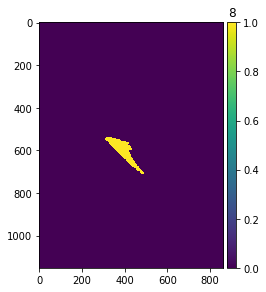

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:06<00:00,  2.85it/s]


In [21]:
label_image = label(segments)
objects = np.unique(label_image)

numbers_patches = 50

for i in tqdm(objects):
    obj = np.where(label_image == i, 1, 0)
    patches = get_patches(obj, image, patch_size = 20)
    dissimilarities, correlations, contrast, homogeneity, ASM, energy = get_stats(patches)

    if np.mean(dissimilarities) < 5 and np.mean(homogeneity) > 0.1 and np.mean(correlations) > 0.4:
        print('dissimilarities', np.mean(dissimilarities))
        print('correlation', np.mean(correlations))
        print('contrast', np.mean(contrast))
        print('homogeneity', np.mean(homogeneity))
        print('ASM', np.mean(ASM))
        print('energy', np.mean(energy))
        print('<<<<<switch>>>>>')
        imshow(obj)
        plt.title(str(i))
        plt.show()